In [2]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import single_MTU_opt
import multiple_MTU_opt
import matplotlib.pyplot as plt
from multiple_MTU_opt_modified import load_values
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%load_ext autoreload

In [2]:
# load the data from csv files
aFRR_energy_prices = pd.read_csv('aFRRenergymarket_2025-03-10_to_2025-03-15.csv')
spotprices = pd.read_csv('spotprices_2025-03-10_to_2025-03-15.csv')
aFRR_energy_prices = aFRR_energy_prices.fillna(0)
aFRR_energy_prices['SecondUTC'] = pd.to_datetime(aFRR_energy_prices['SecondUTC'])
aFRR_energy_prices = aFRR_energy_prices.drop(columns=['PriceArea'])
aFRR_energy_prices = aFRR_energy_prices.set_index('SecondUTC').resample('4s').mean().reset_index()
spotprices['HourUTC'] = pd.to_datetime(spotprices['HourUTC'])
df = pd.merge(aFRR_energy_prices, spotprices[['HourUTC','SpotPriceEUR']], how='left', left_on='SecondUTC', right_on='HourUTC')
df = df.drop(columns=['HourUTC'])
df['SpotPriceEUR'] =  df['SpotPriceEUR'].ffill()
MTU_df = df[df['SecondUTC'].dt.second == 0]
MTU_df = MTU_df[MTU_df['SecondUTC'].dt.minute % 15 == 0]
MTU_df.reset_index(drop = True, inplace = True)
output_singleMTU = single_MTU_opt.load_values(MTU_df)

Set parameter Username
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-12500H, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 14 rows, 9 columns and 28 nonzeros
Model fingerprint: 0xea53fda3
Model has 1 quadratic objective term
Model has 1 quadratic constraint
Variable types: 5 continuous, 4 integer (2 binary)
Coefficient statistics:
  Matrix range     [3e-01, 1e+06]
  QMatrix range    [5e-01, 5e-01]
  QLMatrix range   [5e-01, 1e+00]
  Objective range  [2e+01, 2e+01]
  QObjective range [5e+01, 5e+01]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+01, 2e+06]
  QRHS range       [4e+01, 4e+01]
Presolve removed 14 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Soluti

In [3]:
output_singleMTU['Total_bids (MW)'] = output_singleMTU['Bid Up (MW)'] - output_singleMTU['Bid Down (MW)']
output_singleMTU['Total Activated (MWh)'] = output_singleMTU['ECleared Up (MWh)'] - output_singleMTU['ECleared Down (MWh)']
output_singleMTU['Total Bid (Eur/MWh)'] = output_singleMTU.apply(lambda row: row['Pbid Up (Eur/MWh)'] if row['Activation 1 - Up 0 - Down'] == 1 
                                 else row['Pbid Down (Eur/MWh)'] if row['Activation 1 - Up 0 - Down'] == 0 
                                 else 0, axis=1)

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows = 4, cols = 1, shared_xaxes=True, vertical_spacing=0.01)
fig.add_trace(go.Scatter(x=MTU_df['SecondUTC'], y=MTU_df['aFRR_UpActivatedPriceEUR'], mode='lines', name='aFRR_UpActivatedPriceEUR'), row = 1, col = 1)
fig.add_trace(go.Scatter(x=MTU_df['SecondUTC'], y=MTU_df['aFRR_DownActivatedPriceEUR'], mode='lines', name='aFRR_DownActivatedPriceEUR'), row = 1, col = 1)

fig.add_trace(go.Scatter(x=MTU_df['SecondUTC'], y=output_singleMTU['Total_bids (MW)'] , mode='lines', name='Total_bids (MW)'), row = 2, col = 1)
fig.add_trace(go.Scatter(x=MTU_df['SecondUTC'], y=output_singleMTU['Total Bid (Eur/MWh)'], mode='lines', name='Total Bid (Eur/MWh)'), row = 3, col = 1)
fig.add_trace(go.Scatter(x=MTU_df['SecondUTC'], y=MTU_df['SpotPriceEUR'], mode='lines', name='SpotPriceEUR'), row = 3, col = 1)

fig.add_trace(go.Scatter(x=MTU_df['SecondUTC'], y=output_singleMTU['Total Activated (MWh)'], mode='lines', name='Total Activated (MWh)'), row = 4, col = 1)

fig.update_layout(title='Output of OP',xaxis_title='Time',yaxis1_title='Price (EUR/MWh)',yaxis2_title='Bid MW',yaxis3_title='Bid Price (EUR/MWh)',yaxis4_title='Energy Activated (MWh)',
                  yaxis3=dict(range=[-10, 300]), 
                  legend_title='Legend',template='plotly_white')
fig.show()

In [ ]:
output['Total Bid (Eur/MWh)'] = output.apply(lambda row: row['Pbid Up (Eur/MWh)'] if row['Activation 1 - Up 0 - Down'] == 1 
                                 else row['Pbid Down (Eur/MWh)'] if row['Activation 1 - Up 0 - Down'] == 0 
                                 else 0, axis=1)
output['Total Bid (Mwh)'] = output.apply(lambda row: row['Ebid Up (MWh)'] if row['Activation 1 - Up 0 - Down'] == 1 
                                 else -row['Ebid Down (MWh)'] if row['Activation 1 - Up 0 - Down'] == 0 
                                 else 0, axis=1)

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows = 3, cols = 1, shared_xaxes=True, vertical_spacing=0.01)
fig.add_trace(go.Scatter(x=MTU_df['SecondUTC'], y=output['Total Bid (Eur/MWh)'], mode='lines', name='Total Bid (Eur/MWh)'), row = 1, col = 1)

fig.add_trace(go.Scatter(x=MTU_df['SecondUTC'], y=output['Total Bid (Mwh)'], mode='lines', name='Total Bid (Mwh)'), row = 2, col = 1)

fig.add_trace(go.Scatter(x=MTU_df['SecondUTC'], y=output['Activation 1 - Up 0 - Down'], mode='lines', name='Activation 1 - Up 0 - Down'), row = 3, col = 1)

fig.update_layout(title='Output of OP',xaxis_title='Time',yaxis1_title='Total Bid (Eur/MWh)',yaxis2_title='Total Bid (Mwh)',yaxis3_title='Activation', 
                  legend_title='Legend',template='plotly_white')
fig.show()

In [43]:
horizon = 8
activation_rate = 0.2

# load the data from csv files
aFRR_energy_prices = pd.read_csv('aFRRenergymarket_2025-03-10_to_2025-03-15.csv')
spotprices = pd.read_csv('spotprices_2025-03-10_to_2025-03-15.csv')
aFRR_energy_prices = aFRR_energy_prices.fillna(0)
aFRR_energy_prices['SecondUTC'] = pd.to_datetime(aFRR_energy_prices['SecondUTC'])
aFRR_energy_prices = aFRR_energy_prices.drop(columns=['PriceArea'])
aFRR_energy_prices = aFRR_energy_prices.set_index('SecondUTC').resample('4s').mean().reset_index()
spotprices['HourUTC'] = pd.to_datetime(spotprices['HourUTC'])
df = pd.merge(aFRR_energy_prices, spotprices[['HourUTC','SpotPriceEUR']], how='left', left_on='SecondUTC', right_on='HourUTC')
df = df.drop(columns=['HourUTC'])
df['SpotPriceEUR'] =  df['SpotPriceEUR'].ffill()
MTU_df = df[df['SecondUTC'].dt.second == 0]
MTU_df = MTU_df[MTU_df['SecondUTC'].dt.minute % 15 == 0]
MTU_df.reset_index(drop = True, inplace = True)
MTU_df['Total MWh activated'] = activation_rate
MTU_df['UpCapacityBid'] = 0
MTU_df['DownCapacityBid'] = 0

In [44]:
output, md = multiple_MTU_opt.load_values(MTU_df, start = 20, horizon = horizon)
output_df = pd.DataFrame.from_dict(dict([(k, pd.Series(v)) for k, v in output.items()]))
output_df['Total_bids (MWh)'] = output_df['Ebid Up Cleared (MWh)'] - output_df['Ebid Down Cleared (MWh)']
output_df['Total Bid (Eur/MWh)'] = output_df.apply(lambda row: row['Pbid Up (Eur/MWh)'] if row['Activation 1 - Up 0 - Down'] == 1 
                                 else row['Pbid Down (Eur/MWh)'] if row['Activation 1 - Up 0 - Down'] == 0 
                                 else 0, axis=1)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-12500H, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 112 rows, 72 columns and 238 nonzeros
Model fingerprint: 0xda788953
Model has 8 quadratic objective terms
Model has 8 quadratic constraints
Variable types: 16 continuous, 56 integer (16 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [2e-01, 2e-01]
  QLMatrix range   [2e-01, 1e+00]
  Objective range  [3e+00, 1e+01]
  QObjective range [7e+00, 7e+01]
  Bounds range     [1e+00, 5e+01]
  RHS range        [9e+00, 2e+06]
  QRHS range       [4e+01, 4e+01]
Presolve removed 92 rows and 55 columns
Presolve time: 0.00s
Presolved: 22 rows, 19 columns, 64 nonzeros
Variable types: 0 continuous, 19 integer (2 binary)
Found heuristic solution: objective -0.0000000
Found heuristic solution: objective 1651

Objective value: 2273.59


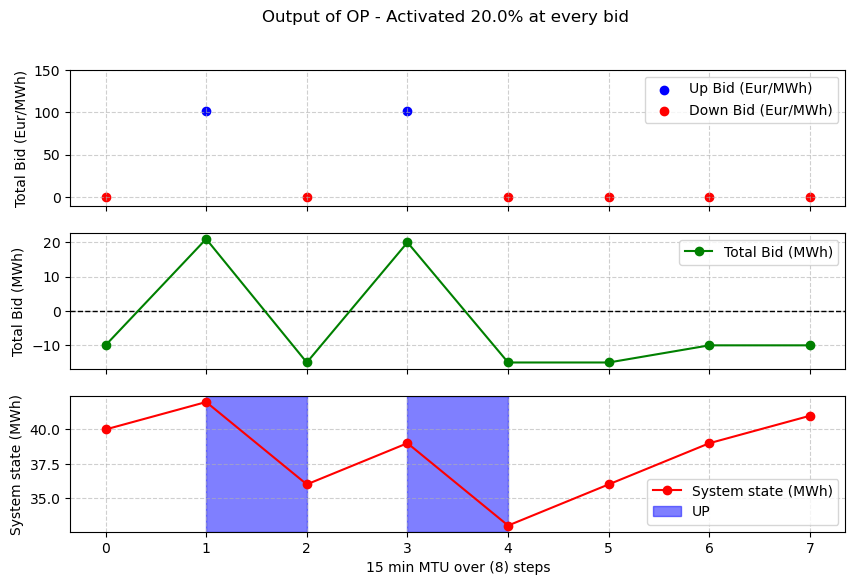

In [45]:

print(f'Objective value: {output_df["Objective Value"][0]}')

# Create figure and subplots
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10, 6))

# Plot data
axes[0].scatter(output_df.index, output_df['Pbid Up (Eur/MWh)'], label='Up Bid (Eur/MWh)', color='b', marker='o')
axes[0].scatter(output_df.index, output_df['Pbid Down (Eur/MWh)'], label='Down Bid (Eur/MWh)', color='r', marker='o')
axes[0].set_ylim(-10, 150)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1].plot(output_df.index, output_df['Total_bids (MWh)'], label='Total Bid (MWh)', color='g', marker='o')
axes[2].plot(output_df.index, output_df['System state (MWh)'], label='System state (MWh)', color='r', marker='o')

activation_series = output_df['Activation 1 - Up 0 - Down']
added_labels = set()

for i in range(len(activation_series) - 1):
    if activation_series.iloc[i] == 1:
        label = 'UP' if 'UP' not in added_labels else None
        axes[2].axvspan(output_df.index[i], output_df.index[i + 1], color='blue', alpha=0.5, label=label)
        added_labels.add('UP')
    
    if output_df['Total_bids (MWh)'].iloc[i] == 0:
        label = 'No Bids placed' if 'No Bids placed' not in added_labels else None
        axes[2].axvspan(output_df.index[i], output_df.index[i + 1], color='grey', alpha=0.5, label=label)
        added_labels.add('No Bids placed')

# Labels and titles
axes[0].set_ylabel('Total Bid (Eur/MWh)')
axes[1].set_ylabel('Total Bid (MWh)')
axes[2].set_ylabel('System state (MWh)')
axes[2].set_xlabel(f'15 min MTU over ({horizon}) steps')

# Legends
for ax in axes:
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

plt.suptitle(f'Output of OP - Activated {activation_rate * 100}% at every bid')
plt.show()


Run with forecasted data

In [3]:
horizon = 8
activation_rate = 0.2
folder_path = "D:\\ms\\January 2024\\Thesis\\Boiler-Bidding-model\\Datasets\\"

# load the data from csv files
aFRR_UP_prices = pd.read_csv(folder_path + 'Up_Price_Forecast_backtest.csv')
spotprices = pd.read_csv(folder_path + 'spotprice_2025-03-25_to_2025-03-30.csv')
aFRR_DOWN_prices = pd.read_csv(folder_path + 'Down_Price_Forecast_backtest.csv')
aFRR_UP_prices['time'] = pd.to_datetime(aFRR_UP_prices['time'])
aFRR_DOWN_prices['time'] = pd.to_datetime(aFRR_DOWN_prices['time'])
spotprices['time'] = pd.to_datetime(spotprices['HourUTC'])
aFRR_UP_prices = aFRR_UP_prices.set_index('time').resample('4s').ffill()
aFRR_DOWN_prices = aFRR_DOWN_prices.set_index('time').resample('4s').ffill()
spotprices = spotprices.set_index('time').resample('4s').ffill()

temp = pd.merge(aFRR_UP_prices, aFRR_DOWN_prices, how='left', left_on='time', right_on='time')
df = pd.merge(temp, spotprices['SpotPriceEUR'], how='left', left_on='time', right_on='time')
df.reset_index(inplace=True)
df['activation_rate'] = activation_rate
df['UpCapacityBid'] = 0
df['DownCapacityBid'] = 0

md, result_dict, results = load_values(df, start = 1801, horizon = horizon)

results['Bid (MW)'] = results.apply(lambda row: row['Bid Up (MW)'] if row['Activation 1 - Up 0 - Down'] == 1 else -row['Bid Down (MW)'] if row['Activation 1 - Up 0 - Down'] == 0 else 0, axis=1)
results['Energy Cleared (MWh)'] = results.apply(lambda row: row['Energy Up Cleared (MWh)'] if row['Activation 1 - Up 0 - Down'] == 1 else -row['Energy Down Cleared (MWh)'] if row['Activation 1 - Up 0 - Down'] == 0 else 0, axis=1)
results['Total Bid (Eur/MWh)'] = results.apply(lambda row: row['Pbid Up (Eur/MWh)'] if row['Activation 1 - Up 0 - Down'] == 1 else row['Pbid Down (Eur/MWh)'] if row['Activation 1 - Up 0 - Down'] == 0 else 0, axis=1)
results.rename(columns={'time':'SecondUTC'}, inplace=True)

fig = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.01,row_heights=[0.25, 0.25, 0.25, 0.25] )

# Add traces
fig.add_trace(go.Scatter(x=results['SecondUTC'], y=results['aFRR_UpActivatedPriceEUR'], mode='lines', name='aFRR_UpActivatedPriceEUR'), row=1, col=1)
fig.add_trace(go.Scatter(x=results['SecondUTC'], y=results['SpotPriceEUR'], mode='lines', name='SpotPriceEUR'), row=1, col=1)
fig.add_trace(go.Scatter(x=results['SecondUTC'], y=results['Total Bid (Eur/MWh)'], mode='lines', name='Total Bid (Eur/MWh)'), row=1, col=1)

fig.add_trace(go.Scatter(x=results['SecondUTC'], y=results['Energy Cleared (MWh)'], mode='lines', name='Energy Cleared (MWh)'), row=2, col=1)
fig.add_trace(go.Scatter(x=results['SecondUTC'], y=results['System state (MWh)'], mode='lines', name='System state (MWh)'), row=3, col=1)
fig.add_trace(go.Scatter(x=results['SecondUTC'], y=results['Bid (MW)'], mode='lines', name='Total bid (MW)'), row=4, col=1)

# Update layout with size and borders
fig.update_layout(title='Output of OP',xaxis_title='Time', yaxis1_title='Price (EUR/MWh)', yaxis2_title='Energy Cleared (MWh)',yaxis3_title='System state (MWh)', yaxis4_title='Bid MW',  
legend_title='Legend',template='plotly_white',height=800,  margin=dict(t=60, b=60, l=60, r=60),  showlegend=True)

for i in range(1, 5):
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black', row=i, col=1)
    fig.update_xaxes(showline=True, linewidth=2, linecolor='black', row=i, col=1)

fig.show()


Set parameter Username
Set parameter LicenseID to value 2576244
Academic license - for non-commercial use only - expires 2025-10-30
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-12500H, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 14448 rows, 7240 columns and 36078 nonzeros
Model fingerprint: 0x9f7ad801
Model has 3600 quadratic objective terms
Model has 1800 quadratic constraints
Variable types: 5416 continuous, 1824 integer (1808 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+06]
  QMatrix range    [2e-01, 2e-01]
  QLMatrix range   [2e-01, 1e+00]
  Objective range  [1e-01, 1e+01]
  QObjective range [3e-01, 1e+03]
  Bounds range     [1e+00, 5e+01]
  RHS range        [9e+00, 2e+06]
  QRHS range       [4e+01, 4e+01]
Presolve added 4541 rows and 0 columns
Presolve removed 0 rows and 16 columns
Presolve time: 

In [7]:
# %%
from multiple_MTU_opt_modified import load_values
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

if __name__ == '__main__':
    horizon = 8
    activation_rate = 0.2
    folder_path = "D:\\ms\\January 2024\\Thesis\\Boiler-Bidding-model\\Datasets\\"

    # load the data from csv files
    aFRR_UP_prices = pd.read_csv(folder_path + 'Up_Price_Forecast_backtest.csv')
    spotprices = pd.read_csv(folder_path + 'spotprice_2025-03-25_to_2025-03-30.csv')
    aFRR_DOWN_prices = pd.read_csv(folder_path + 'Down_Price_Forecast_backtest.csv')
    aFRR_UP_prices['time'] = pd.to_datetime(aFRR_UP_prices['time'])
    aFRR_DOWN_prices['time'] = pd.to_datetime(aFRR_DOWN_prices['time'])
    spotprices['time'] = pd.to_datetime(spotprices['HourUTC'])
    aFRR_UP_prices = aFRR_UP_prices.set_index('time').resample('4s').ffill()
    aFRR_DOWN_prices = aFRR_DOWN_prices.set_index('time').resample('4s').ffill()
    spotprices = spotprices.set_index('time').resample('4s').ffill()

    temp = pd.merge(aFRR_UP_prices, aFRR_DOWN_prices, how='left', left_on='time', right_on='time')
    df = pd.merge(temp, spotprices['SpotPriceEUR'], how='left', left_on='time', right_on='time')
    df.reset_index(inplace=True)
    df['activation_rate'] = activation_rate
    df['UpCapacityBid'] = 0
    df['DownCapacityBid'] = 0

    df = df[435:].reset_index(drop = True) # starting at '2025-03-25 12:00:00'

    output = pd.DataFrame()
    # %%
    indices = list(range(0, 10000, 1800+1))
    for start in indices:
        df1 = df.copy()
        df1.rename(columns={'aFRR_UP_Price_prediction':'aFRR_Up_Price', 'aFRR_DOWN_Price_prediction': 'aFRR_Down_Price'}, inplace=True)

        md, result_dict, results = load_values(df1, start = start, horizon = horizon)
        results['Bid (MW)'] = results.apply(lambda row: row['Bid Up (MW)'] if row['Activation 1 - Up 0 - Down'] == 1 else -row['Bid Down (MW)'] if row['Activation 1 - Up 0 - Down'] == 0 else 0, axis=1)
        results.rename(columns={'time':'SecondUTC'}, inplace=True)
        predict = results[['SecondUTC', 'Bid (MW)', 'Objective Value']].rename(columns={'Bid (MW)': 'Bid (MW)_predict', 'Objective Value': 'Objective Value_predict'})
        df1.rename(columns={'aFRR_Up_Price':'aFRR_UP_Price_prediction', 'aFRR_Down_Price': 'aFRR_DOWN_Price_prediction'}, inplace=True)

        df1.rename(columns={'aFRR_UpActivatedPriceEUR':'aFRR_Up_Price', 'aFRR_DownActivatedPriceEUR': 'aFRR_Down_Price'}, inplace=True)
        md, result_dict, results = load_values(df1, start = start, horizon = horizon)
        results['Bid (MW)'] = results.apply(lambda row: row['Bid Up (MW)'] if row['Activation 1 - Up 0 - Down'] == 1 else -row['Bid Down (MW)'] if row['Activation 1 - Up 0 - Down'] == 0 else 0, axis=1)
        results.rename(columns={'time':'SecondUTC'}, inplace=True)
        
        actual = results[['SecondUTC', 'Bid (MW)', 'Objective Value']].rename(columns={'Bid (MW)': 'Bid (MW)_actual', 'Objective Value': 'Objective Value_actual'})
        df1.rename(columns={'aFRR_Up_Price':'aFRR_UpActivatedPriceEUR', 'aFRR_Down_Price': 'aFRR_DownActivatedPriceEUR'}, inplace=True)
        output = actual.merge(predict, on='SecondUTC', how='outer')


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-12500H, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 14448 rows, 7240 columns and 36078 nonzeros
Model fingerprint: 0x7c37d575
Model has 3600 quadratic objective terms
Model has 1800 quadratic constraints
Variable types: 5416 continuous, 1824 integer (1808 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+06]
  QMatrix range    [2e-01, 2e-01]
  QLMatrix range   [2e-01, 1e+00]
  Objective range  [3e-02, 1e+01]
  QObjective range [6e-02, 1e+03]
  Bounds range     [1e+00, 5e+01]
  RHS range        [9e+00, 2e+06]
  QRHS range       [4e+01, 4e+01]
Presolve added 1171 rows and 0 columns
Presolve removed 0 rows and 1138 columns
Presolve time: 0.25s
Presolved: 17164 rows, 7647 columns, 47643 nonzeros
Variable types: 6080 continuous, 1567 integer (1552 binary)

Root relaxa

KeyError: 'aFRR_UpActivatedPriceEUR'